# Assignment NLP - Fake News Classifier

By Ida Davidsson - O1 MBD

In [151]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from nltk.classify import MaxentClassifier
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from nltk.stem.snowball import SnowballStemmer
import matplotlib as mpl
import matplotlib.pyplot as plt
% matplotlib inline
from wordcloud import WordCloud, STOPWORDS
from subprocess import check_output

Import data

In [152]:
train = pd.read_csv('~/Documents/Modules/Term 3/NLP/1stAssignmentTextClassification/fake_or_real_news_training.csv')
test = pd.read_csv('~/Documents/Modules/Term 3/NLP/1stAssignmentTextClassification/fake_or_real_news_test.csv')

### Data Exploration

In [153]:
train.head(5)

,ID,title,text,label,X1,X2
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE,NaN,NaN
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE,NaN,NaN
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL,NaN,NaN
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE,NaN,NaN
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL,NaN,NaN


In [154]:
test.head(5)

,ID,title,text
0,10498,September New Homes Sales Rise——-Back To 1992 ...,September New Homes Sales Rise Back To 1992 Le...
1,2439,Why The Obamacare Doomsday Cult Can't Admit It...,But when Congress debated and passed the Patie...
2,864,"Sanders, Cruz resist pressure after NY losses,...",The Bernie Sanders and Ted Cruz campaigns vowe...
3,4128,Surviving escaped prisoner likely fatigued and...,Police searching for the second of two escaped...
4,662,Clinton and Sanders neck and neck in Californi...,No matter who wins California's 475 delegates ...


Some wordclouds to visualise the data

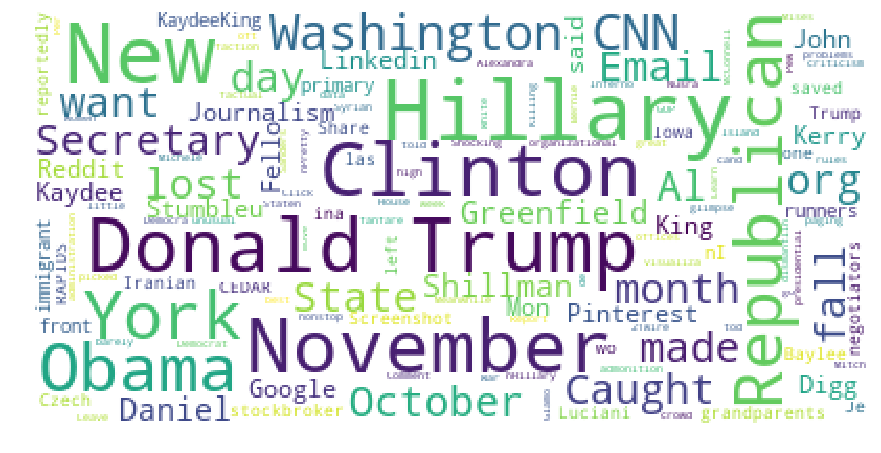

In [155]:
stopwords = set(STOPWORDS)

# text wordcloud
wordcloud_text = WordCloud(
                          background_color='white',
                          stopwords=stopwords,
                          max_words=200,
                          max_font_size=40, 
                          random_state=42
                         ).generate(str(train['text']))

print(wordcloud_text)
fig = plt.figure(1)
plt.figure(figsize=(15,10))
plt.imshow(wordcloud_text)
plt.axis('off')
plt.show()

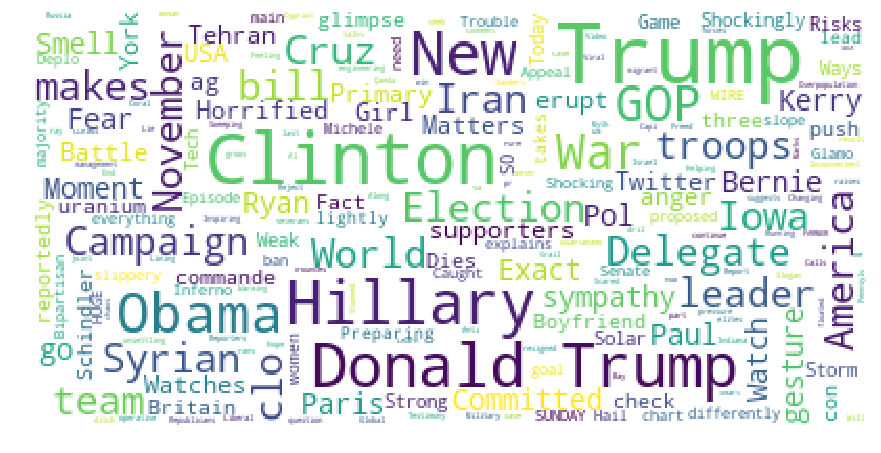

In [156]:
# title wordcloud
wordcloud_title = WordCloud(
                          background_color='white',
                          stopwords=stopwords,
                          max_words=200,
                          max_font_size=40, 
                          random_state=42
                         ).generate(str(train['title']))

print(wordcloud_title)
fig = plt.figure(1)
plt.figure(figsize=(15,10))
plt.imshow(wordcloud_title)
plt.axis('off')
plt.show()

### Data cleaning 

We will delete the few rows which have been read faulty. This is OK since it is such a small proportion of the overall data.

In [157]:
to_del = train[train['X1'].notnull()].index.tolist()

# Deciding to delete the rows with faulty data as it's such a small percentage
train = train.drop(to_del)

In [158]:
train.describe()

,ID
count,3966.000000
mean,5286.754665
std,3043.858416
min,3.000000
25%,2687.250000
50%,5257.000000
75%,7906.500000
max,10557.000000


In [159]:
Y = train['label'] # store Y label
del train['label'] # delete Y label from train data

### Vectorisation

Let's start with vectorising words in the data, using Count and TF-IDF vectorizers

In [160]:
# values in trainig data
x_text = train.text.values
x_title = train.title.values

# values in test data
x_test = test.text.values
id_test = test.ID.values

In [161]:
cv = CountVectorizer(stop_words = 'english')

# Count vectorizer for the main text
count_train_text = cv.fit_transform(x_text)

# Count vectorizer for the title
count_train_title = cv.fit_transform(x_title)

In [162]:
tfidf = TfidfVectorizer(stop_words = 'english')

# TF-IDF vectorizer for main text
tfidf_train_text = tfidf.fit_transform(x_text)

# TF-IDF vectorizer for the title
tfidf_train_title = tfidf.fit_transform(x_title)

We will split the training data into train and test in order to test our future model. We will also split the title in case we can use it to improve our model.

In [163]:
# split CV text
CVx_train_text, CVx_test_text, CVy_train_text, CVy_test_text = train_test_split(count_train_text, Y, test_size = 0.2, random_state = 42)

# split CV title
CVx_train_title, CVx_test_title, CVy_train_title, CVy_test_title = train_test_split(count_train_title, Y, test_size = 0.2, random_state = 42)


In [164]:
# split TF-IDF text
TFx_train_text, TFx_test_text, TFy_train_text, TFy_test_text = train_test_split(tfidf_train_text, Y, test_size=0.2, random_state = 42)

# split TF-IDF title
TFx_train_title, TFx_test_title, TFy_train_title, TFy_test_title = train_test_split(tfidf_train_title, Y, test_size=0.2, random_state = 42)


## 0. Base models

First, we will try a few classifiers without any specific parameters, which we can use to compare performance when we add more parameters.

In [165]:
# base function for the models

def model_accuracy (model):
    model.fit(CVx_train_text, CVy_train_text)
    predictions = model.predict(CVx_test_text)
    cvscore = accuracy_score(CVy_test_text, predictions)
    
    model.fit(TFx_train_text, TFy_train_text)
    predictions = model.predict(TFx_test_text)
    tfscore = accuracy_score(TFy_test_text, predictions)
    
    print('CV Accuracy:   %0.3f' % cvscore)
    print('TF Accuracy:   %0.3f' % tfscore)

### 0.1 Naive Bayes

In [166]:
nb = MultinomialNB()
    
model_accuracy(nb)

CV Accuracy:   0.882
TF Accuracy:   0.805


### 0.2 Random Forest

In [167]:
rf = RandomForestClassifier()

model_accuracy(rf)

CV Accuracy:   0.838
TF Accuracy:   0.851


### 0.3 XGBoost Classifier

In [168]:
xgb = XGBClassifier()

model_accuracy(xgb)

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


CV Accuracy:   0.888
TF Accuracy:   0.894


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


### 0.4 SVM

In [169]:
sgd = SGDClassifier()

model_accuracy(sgd)

CV Accuracy:   0.906
TF Accuracy:   0.936


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


Out of the base models, SVM with TF-IDF Vectorisation gave 93.6% accuracy. We will now try to improve the vectorisers with n-grams.

## 1. Models with N-gram vectorization

We will go through the same steps as before, when vectorising and splitting the data. However, this time N-grams will be included.

After some trial and error, the ngram range of (1, 2) was deemed to be the most effective.

In [170]:
cv_1 = CountVectorizer(stop_words='english', ngram_range=(1,2))

# Count vectorizer for the main text
count_train_text_1 = cv_1.fit_transform(x_text)

# Count vectorizer for the title
count_train_title_1 = cv_1.fit_transform(x_title)

In [171]:
tfidf_1 = TfidfVectorizer(stop_words = 'english', ngram_range=(1,2))

# TF-IDF vectorizer for main text
tfidf_train_text_1 = tfidf_1.fit_transform(x_text)

# TF-IDF vectorizer for the title
tfidf_train_title_1 = tfidf_1.fit_transform(x_title)

Train/Test split

In [172]:
# split CV text
CVx_train_text1, CVx_test_text1, CVy_train_text1, CVy_test_text1 = train_test_split(count_train_text_1, Y, test_size = 0.2, random_state = 42)

# split CV title
CVx_train_title1, CVx_test_title1, CVy_train_title1, CVy_test_title1 = train_test_split(count_train_title_1, Y, test_size = 0.2, random_state = 42)

In [173]:
# split TF-IDF text
TFx_train_text1, TFx_test_text1, TFy_train_text1, TFy_test_text1 = train_test_split(tfidf_train_text_1, Y, test_size=0.2, random_state = 42)

# split TF-IDF title
TFx_train_title1, TFx_test_title1, TFy_train_title1, TFy_test_title1 = train_test_split(tfidf_train_title_1, Y, test_size=0.2, random_state = 42)

New accuracy model

In [174]:
def model_accuracy_1 (model):
    model.fit(CVx_train_text1, CVy_train_text1)
    predictions = model.predict(CVx_test_text1)
    cvscore = accuracy_score(CVy_test_text1, predictions)
    
    model.fit(TFx_train_text1, TFy_train_text1)
    predictions = model.predict(TFx_test_text1)
    tfscore = accuracy_score(TFy_test_text1, predictions)
    
    print('CV Accuracy:   %0.3f' % cvscore)
    print('TF Accuracy:   %0.3f' % tfscore)

### 1.1 Naive Bayes

In [175]:
model_accuracy_1(nb)

CV Accuracy:   0.897
TF Accuracy:   0.797


### 1.2 Random Forest

In [176]:
model_accuracy_1(rf)

CV Accuracy:   0.839
TF Accuracy:   0.832


### 1.3 XGBoost

In [177]:
model_accuracy_1(xgb)

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


CV Accuracy:   0.883
TF Accuracy:   0.894


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


### 1.4 SVM

In [178]:
model_accuracy_1(sgd)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


CV Accuracy:   0.895
TF Accuracy:   0.927


With N-gram vectorization, SVM with TF-IDF Vectorisation gave 92.7%

## 2. Count Vectoriser with TF-IDF transformer pipeline 

We will now create a pipeline combine CountVectorizer and TFIDFTransformer combined, with n-gram range = (1, 2) and english stopwords, like earlier.

Train/Test split

In [179]:
x_train_text2, x_test_text2, y_train_text2, y_test_text2 = train_test_split(x_text, Y, test_size = 0.2, random_state = 42)

Accuracy model

In [180]:
def model_accuracy_2 (model):
    model.fit(x_train_text2, y_train_text2)
    predictions = model.predict(x_test_text2)
    cvscore = accuracy_score(y_test_text2, predictions)

    print('Accuracy:   %0.3f' % cvscore)

### 2.1 Naive Bayes

In [181]:
comb_text_nb = Pipeline([('vect', CountVectorizer(stop_words='english', ngram_range=(1,2))), ('tfidf', TfidfTransformer()), ('nb', MultinomialNB())])

model_accuracy_2(comb_text_nb)

Accuracy:   0.791


### 2.2 Random Forest

In [182]:
comb_text_rf = Pipeline([('vect', CountVectorizer(stop_words='english', ngram_range=(1,2))), ('tfidf', TfidfTransformer()), ('rf', RandomForestClassifier())])

model_accuracy_2(comb_text_rf)

Accuracy:   0.839


### 2.3 XGBoost

In [183]:
comb_text_xgb = Pipeline([('vect', CountVectorizer(stop_words='english', ngram_range=(1,2))), ('tfidf', TfidfTransformer()), ('xgb', XGBClassifier())])

model_accuracy_2(comb_text_xgb)

Accuracy:   0.895


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


### 2.4 SVM

In [184]:
comb_text_svm = Pipeline([('vect', CountVectorizer(stop_words='english', ngram_range=(1,2))), ('tfidf', TfidfTransformer()), ('svm', SGDClassifier())])

model_accuracy_2(comb_text_svm)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


Accuracy:   0.937


## 3. Stemming with SVM

We will now attempt to further improve our accuracy by stemming the words in the text.

Since SVM is clearly the outperformer, we will only perform stemming with SVM Classifier.

In [185]:
stemmer = SnowballStemmer("english", ignore_stopwords=True)

class StemmedCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(StemmedCountVectorizer, self).build_analyzer()
        return lambda doc: ([stemmer.stem(w) for w in analyzer(doc)])
    
stemmed_count_vect = StemmedCountVectorizer(stop_words='english', ngram_range=(1,2))

text_mnb_stemmed = Pipeline([('vect', stemmed_count_vect), ('tfidf', TfidfTransformer()), 
                             ('svm', SGDClassifier())])

model_accuracy_2(text_mnb_stemmed)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


Accuracy:   0.928


Stemming did not improve the score, and we conclude that model 2.4 is indeed the best one. We will now make predictions on the test data using that model.

In [186]:
# make predictions
test_predictions = comb_text_svm.predict(x_test)

In [187]:
# convert to CSV for submission
preds = pd.DataFrame({'id':id_test, 'Class':test_predictions})
preds.to_csv('NLP_assignment1_preds1.csv', index = False)